# Isomap
This is the third part in *Manifold Learning: Introduction and Foundational Algorithms*, and the entire project can be viewed at https://github.com/drewwilimitis/Manifold-Learning <br>
<br>
`Drew Wilimitis`

**Isomap** (Isometric mapping) is another one of the foundational algorithms in non-linear dimensionality reduction and manifold learning. Isomap introduces a unique approach to learning global geometric structure, which is based on representing high dimensional datasets with nearest neighbor graphs. The idea is that the distances you travel along the edges of the graph approximate distances along the manifold. <br>
<br>
By learning the intrinsic metric defined along the manifold instead of the metric defined by an external coordinate system, isomap can learn highly complex, non-linear geometric relationships. Additionally, isomap then provides a lower dimensional embedding transformation that preserves the higher dimensional structure.

Before going into the details of the algorithm, we define two important concepts. Given two metric spaces $X$ and $Y$ with metrics $d_x$ and $d_y$, an **Isometry** is a bijective map $f : X \rightarrow Y$ between the two metric spaces that preserves distances: <br>
<br>
$$
d_{Y}(f(a), f(b))=d_{X}(a, b)
$$ <br>
In our case, we would like to find an *isometric* mapping from the manifold where the distance between data points $x_i$ and $x_j$ along the manifold (as the graph **geodesic** distance) is equal to the Euclidean distance between the corresponding lower dimensional output vectors $y_i$ and $y_j$. 

![title](https://upload.wikimedia.org/wikipedia/commons/thumb/6/6a/Spherical_triangle.svg/225px-Spherical_triangle.svg.png)
A triangle formed on the surface of a sphere by the geodesic lengths between points A, B, C. Source: https://en.wikipedia.org/wiki/Geodesic

For any general surface, a **geodesic** is a locally length minimizing path. Geodesics generalize the notion of straight-line shortest paths (in the Euclidean plane) to intrinsically defined surface geometries. In the isomap algorithm, we approximate the shortest path along the surface of the manifold by the **graph geodesic** - the minimally weighted path between two nodes.  

### Algorithm Outline (Isomap): 
**Input:** Data vectors $\mathbf{x_1}, ..., \mathbf{x_n} \in \mathbb{R^d}$ with parameters k (nearest neighbors) and m (embedding dimension)<br>
**Output:** Lower dimensional embedding vectors $\mathbf{y_i}, ..., \mathbf{y_n} \in \mathbb{R^m}$ with $m < d$
<br>
**Steps**: <br>
1. Find the k nearest neighbors for each point and create nearest neighbors graph $G$ with data points $x_i$ as the nodes and edges connecting nearest neighbors. <br>
2. Compute geodesic similarity matrix $D$ with pairwise shortest-path distances along the graph (Dijkstra's algorithm) <br>
3. Apply Multidimensional Scaling to matrix $D$ to form the lower dimensional embedding

### Step 1. kNN graph 

After computing the pairwise distances in the Euclidean space we find the k nearest neighbors for each data point. (either with the $\epsilon$-ball method where you only include neighbors within some $\epsilon$ radius or by just including the k nearest Euclidean distances)


Next, define the graph $$G = ({V, E)}$$ <br>
Let every data point $x_i$ be a node $v \in V$ with edges $e_{i,j}$ connecting every pair $x_i$, $x_j$. Given data points $x_i$, $x_j$ define the corresponding edge weights by: <br>
<br>
$$
\ w_{i,j} = \begin{cases} 
      d(x_i,x_j) & x_j \ \text{is a nearest neighbor of $x_i$} \\
      \infty & otherwise \\ 
   \end{cases}
\\ $$ <br>
This has the effect of essentially only connecting nearest neighbors with edges, since the edge weights are set to $\infty$ otherwise, indicating an infinite graph distance between them. We do this, however, in order to make the kNN graph connected and ensure it satisfies the conditions of the graph algorithms we use.

### <font color='blue'> Example - More on Geodesics and the kNN Graph</font> 

Here we show a 2D example illustrating a kNN graph and we compare geodesic vs. Euclidean distances. 

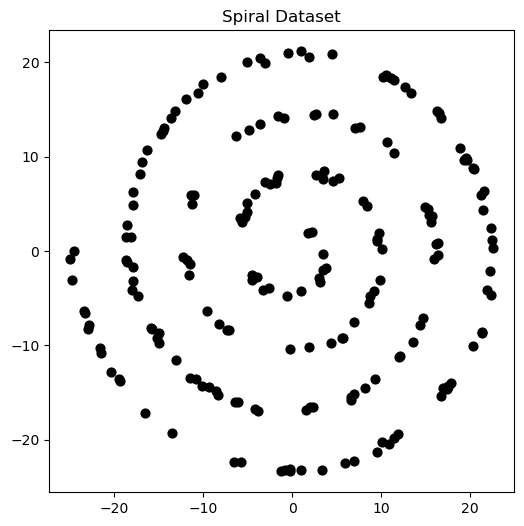

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.figure(figsize=(6,6))
# display multiple outputs within a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all";
np.random.seed(8888)

# spiral dataset
n = np.sqrt(np.random.rand(200,1)) * 1440 * (2*np.pi)/360
d1x = -np.cos(n)*n + np.random.rand(200,1) * 0.8
d1y = np.sin(n)*n + np.random.rand(200,1) * 0.8

plt.scatter(d1x, d1y, c = 'black', s=40)
plt.title('Spiral Dataset')
X = np.hstack((d1x,d1y))
plt.show();

This is a very simple non-linear manifold. The data here approximately lies along this embedded curved in $\mathbb{R^2}$, and looks locally linear. Now we find the k nearest neighbors and draw edges connecting them on the graph. Note that we find these original nearest neighbors by the Euclidean distance in this original space.

In [2]:
# compute pairwise distance matrix to find k nearest neighbors for each x_i in X
from sklearn.metrics import pairwise_distances
dist_matrix = pairwise_distances(X)
dist_matrix.shape

# function that outputs N x k matrix with k nearest neighbors for each observation in X
def nearest_neighbors(X, k):
    # we use k+1 here since Xi will have the shortest distance to itself
    knn_matrix = np.zeros((len(X), k))
    # compute pairwise distances
    dist_matrix = pairwise_distances(X)
    # for each row find indices of k nearest neighbors
    for i in range(len(X)):
        knn_matrix[i] = dist_matrix[i,:].argsort()[1:k+1]
    return knn_matrix

(200, 200)

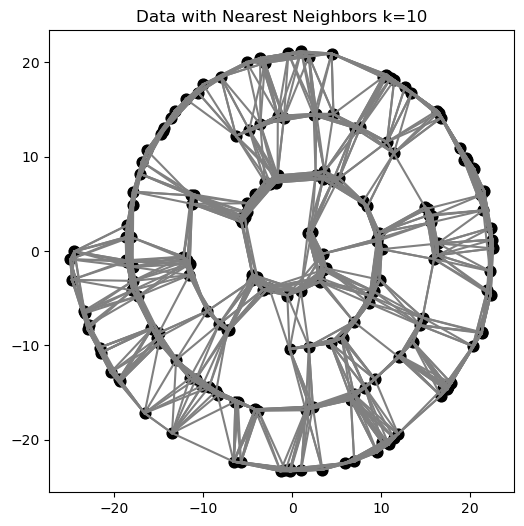

In [3]:
# set number of neighbors and find neighborhood matrix
k = 10
X_neighbors = nearest_neighbors(X, k)

# loop through each data point and draw lines to nearest neighbors
plt.figure(figsize=(6,6))
plt.scatter(X[:,0], X[:,1], alpha=0.3, c='black', s=50);

for i in range(len(X)):
    neighbors = X_neighbors[i]
    for j in range(len(neighbors)):
        plt.plot(X[[i, neighbors.astype('int')[j]], 0], X[[i, neighbors.astype('int')[j]], 1], c='gray')

plt.title('Data with Nearest Neighbors k=' + str(k))
plt.scatter(X[:,0], X[:,1], c='black', s=60)
plt.show();

Now let's look at one region to see how the geodesic distances might better describe the manifold structure than Euclidean distances.

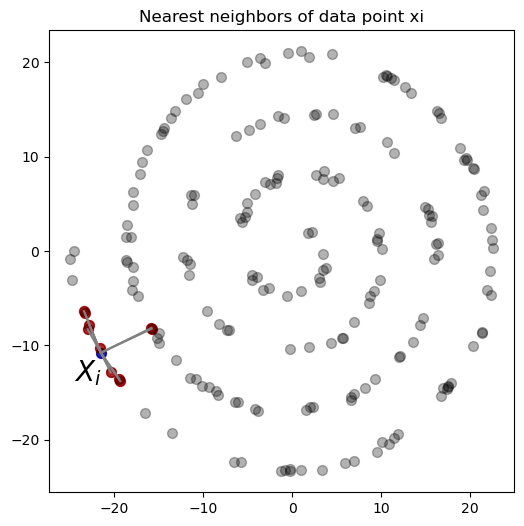

In [4]:
# neighbors for a given xi (first element in X)
neighbors = X_neighbors[0] # indices of neighbors
plt.figure(figsize=(6,6))
plt.scatter(X[0, 0], X[0, 1], c='blue', s=50, alpha=0.8)
plt.text(X[0, 0]-3, X[0, 1] - 3, s='$X_i$', size=20)
plt.scatter(X[neighbors.astype('int'), 0], X[neighbors.astype('int'), 1], c='red', alpha = 0.8, s=50)
for i in range(len(neighbors)):
    plt.plot(X[[0, neighbors.astype('int')[i]], 0], X[[0, neighbors.astype('int')[i]], 1], c='gray')
plt.scatter(X[:,0], X[:,1], alpha=0.3, c='black', s=50)
plt.title('Nearest neighbors of data point xi')
plt.show();

In [5]:
# get coordinates for the neighborhood of xi
xi_nn = []
for i in range(len(neighbors)):
    xi_nn.append(X[neighbors.astype('int')[i]])
xi_nn = np.array(xi_nn)

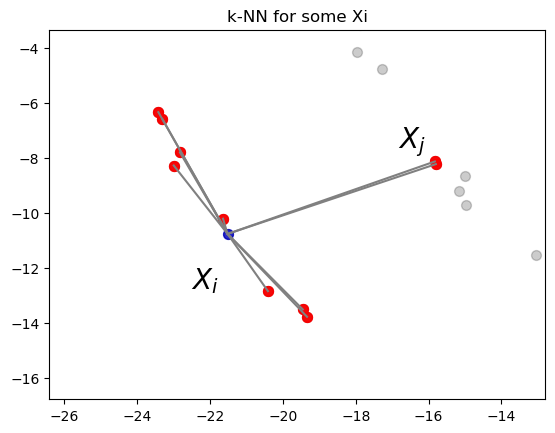

In [6]:
# zoom in on xi with nearest neighbor edges
j = k-1
plt.scatter(X[0, 0], X[0, 1], c='blue', s=50, alpha=0.8)
plt.text(X[0, 0] - 1, X[0, 1] - 2, s='$X_i$', size=20)
plt.text(xi_nn[j][0]-1.0, xi_nn[j][1] + 0.5, s='$X_j$', size=20)
plt.scatter(X[neighbors.astype('int'), 0], X[neighbors.astype('int'), 1], c='red', alpha = 0.8, s=50)
for i in range(len(neighbors)):
    plt.plot(X[[0, neighbors.astype('int')[i]], 0], X[[0, neighbors.astype('int')[i]], 1], c='gray')
plt.scatter(X[:,0], X[:,1], alpha=0.2, c='black', s=50);
plt.scatter(X[neighbors.astype('int'), 0], X[neighbors.astype('int'), 1], c='red', alpha = 0.8, s=50)
plt.title('k-NN for some Xi')
plt.xlim(np.min(xi_nn[:,0])-3,np.max(xi_nn[:,0])+3)
plt.ylim(np.min(xi_nn[:,1]-3),np.max(xi_nn[:,1])+3)
plt.show();

In this case the Euclidean distances give us nearest neighbors that don't necessary provide the nearest neighbors along the manifold. $x_i$ and $x_j$ are close in the 2D Euclidean space, but if you think about only being able to move along the spiral ring manifold then $x_j$ would be further than many other candidate neighbors for $x_i$.<br>
<br>
Using geodesic distances with Isomap helps us uncover this manifold structure, as opposed to using only Euclidean distances (like MDS). Euclidean distances can often fail because of this "short-circuit" problem, where points can be close in the larger external space but far away on the non-linear manifold. <br>
<br>
Additionally, experimenting with different values of k can improve the performance of Isomap here by not allowing too many 'jumps' through the external Euclidean space.

## Step 2. Shortest Path Algorithms and Pairwise Graph Geodesics

![title](https://upload.wikimedia.org/wikipedia/commons/thumb/3/3b/Shortest_path_with_direct_weights.svg/375px-Shortest_path_with_direct_weights.svg.png)

The shortest path from A to F in this figure is given by the path A-C-E-D-F. Source: https://en.wikipedia.org/wiki/Shortest_path_problem

Although this image shows a directed graph and our nearest neighbors graph will be undirected, this figure demonstrates how distances and shortest path geodesics along the graph are computed. The shortest path from some node A to node B is the path that minimizes the weighted sum of the edges in the path.  

We have two prominent algorithms for finding the shortest or minimum weight path between two nodes in a graph: <br>
- Dijkstra's Algorithm <br>
- The Floyd-Warshall Algorithm

I won't go into their implementations too extensively, but the important point is that these algorithms compute pairwise geodesic distances between our data points, which the final input used to find our lower dimensional embedding.

Floyd's Algorithm 
------------------------------------------------------
Floyd's algorithm computes the geodesic distances between all pairs of
points on a graph. Its complexity is $\mathcal O(n^3)$, while Dijkstra runs in $\mathcal O(n^2\log(n))$.

The idea behind Floyd's algorithm is to set the geodesic distances iteratively: <br>
- For neighbors with already defined edge weights let $D_{i,j}$ = $d(x_i, x_j)$ <br>
- Else search through intermediate edges, finding iteratively shortest distances before arriving at the computed geodesic

Floyd's algorithm iterates over k with the following update rule, for $k=1,\dots,n$

$D(i,j) \leftarrow \min(D(i,j), \underbrace{D(i,k)+D(k,j)}_{\text{intermediate edge}})$

Dijkstra's Algorithm
------------------------------------------------------

Dijkstra's algorithm is a little harder to explain succinctly. It is a depth-first search algorithm to find the shortest path between a source node and a target node. It also works in an iterative process that keeps track of unvisited nodes with the lowest weights, and tries finding better intermediate paths through these unvisited nodes, updating the distance from the source node while it goes along.

There's plenty of great resources explaining Dijkstra's algorithm for more details on its implementation and computational complexity, but I provide some pseudocode and an explanation from wikipedia here https://en.wikipedia.org/wiki/Dijkstra%27s_algorithm:

> <br>
1. Mark all nodes unvisited. Create a set of all the unvisited nodes called the unvisited set. <br>
2. Assign to every node a tentative distance value: set it to zero for our initial node and to infinity for all other nodes. Set the initial node as current. <br>
3. For the current node, consider all of its unvisited neighbours and calculate their tentative distances through the current node. Compare the newly calculated tentative distance to the current assigned value and assign the smaller one. For example, if the current node A is marked with a distance of 6, and the edge connecting it with a neighbour B has length 2, then the distance to B through A will be 6 + 2 = 8. If B was previously marked with a distance greater than 8 then change it to 8. Otherwise, keep the current value. <br>
4. When we are done considering all of the unvisited neighbours of the current node, mark the current node as visited and remove it from the unvisited set. A visited node will never be checked again. <br>
5. If the destination node has been marked visited (when planning a route between two specific nodes) or if the smallest tentative distance among the nodes in the unvisited set is infinity (when planning a complete traversal; occurs when there is no connection between the initial node and remaining unvisited nodes), then stop. The algorithm has finished. <br>
6. Otherwise, select the unvisited node that is marked with the smallest tentative distance, set it as the new "current node", and go back to step 3. <br>

Pseudocode for Dijkstra's Algorithm:

![title](https://raw.githubusercontent.com/drewwilimitis/Manifold-Learning/master/images/code.PNG)

Dijkstra's algorithm is most often used in implementations of isomap, and it returns a symmetric, non-negative distance matrix with the pairwise shortest path distances along the graph. This distance matrix can then be used as an input to the previously discussed algorithm - multidimensional scaling. 

## Step 3. Applying Multidimensional Scaling

We now have our pairwise geodesic distance matrix D which we can input to MDS. We use the squared geodesic distances $D^{2}$ to calculate the gram matrix $B$ <br>
<br>
$$\boxed {B = \frac{-1}{2} C_n D^{2} C_{n}^T}$$ <br>
**Note:** $C_{n}$ = Centering matrix, $D^{2}$ = matrix with entries ${d_{ij}^2}$

We can now use the eigendecomposition of B: <br>
<br>
$$B = Y Y^T = V \Lambda V^T$$ <br>
using the fact that $B$ is symmetric, positive definite n x n matrix we have <br>
<br>
$$ \boxed{Y = \Lambda^\frac{1}{2} V^T}$$ 

We can reduce the dimensionality to $m \leq d$: <br>
<br>
$$ \boxed{Y_{m} = \Lambda_{m}^\frac{1}{2} V_{m}^T}$$
<br>
by choosing the first m columns of eigenvector matrix V where $\Lambda_{m}$ is the m x m diagonal submatrix with the m largest eigenvalues. 

We have our lower dimensional output vectors $\mathbf{y_i}, ..., \mathbf{y_n} \in \mathbb{R^m}$. We used the knn graph to calculate geodesic distances, and applied MDS to preserve these geodesic distances, such that we retain information about the manifold structure while reducing the dimensionality.

### <font color='blue'> Example - Graph Geodesics on the Swiss Roll</font>

We now show an example of this k-NN graph and the graph geodesic distances on our favorite dataset for manifold learning: the swiss roll.

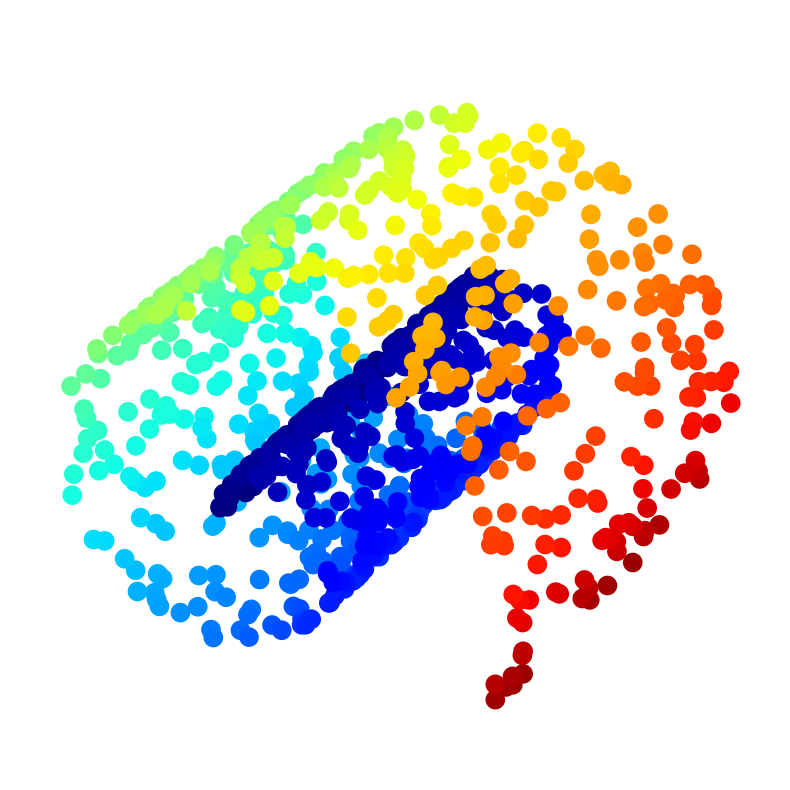

In [7]:
# generate data
n = 1000
x = np.random.rand(2,n)

# swiss roll transformation
v = 3*np.pi/2*(.1 + 2*x[0,:])
X  = np.zeros([3,n])
X[1,:] = 20*x[1,:]
X[0,:] = - np.cos(v)*v
X[2,:] = np.sin(v)*v

from mpl_toolkits.mplot3d import Axes3D

# plot swiss roll
fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(X[0,:], X[1,:], X[2,:], c=plt.cm.jet((X[0,:]**2+X[2,:]**2)/100), s=200, lw=0, alpha=1)
ax.set_xlim(np.min(X[0,:]),np.max(X[0,:]))
ax.set_ylim(np.min(X[1,:]),np.max(X[1,:]))
ax.set_zlim(np.min(X[2,:]),np.max(X[2,:]))
ax.axis("off")
plt.show();

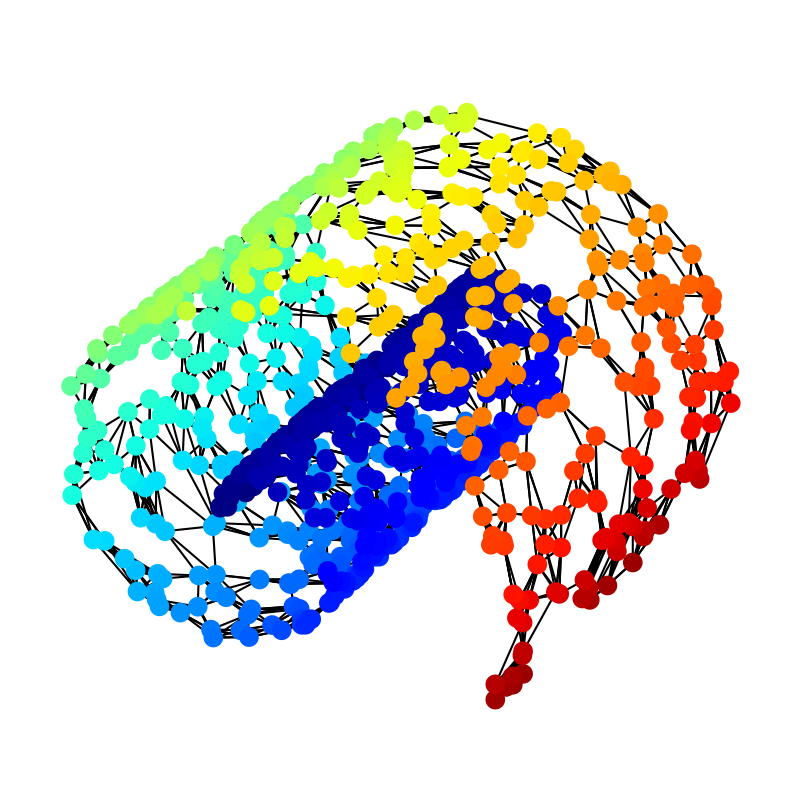

In [8]:
# format X as (n_samples, n_features)
X = np.transpose(X)

fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(111, projection="3d")

# plot original swiss roll
ax.scatter(X[:,0], X[:,1], X[:,2], c=plt.cm.jet((X[:,0]**2+X[:,2]**2)/100), s=200, lw=0, alpha=1);

# loop through each data point and plot lines connecting nearest neighbors
k = 6 # number of nearest neighbors
knn = nearest_neighbors(X, k)
for i in range(len(X)):
    neighbors = knn[i]
    for j in range(len(neighbors)):
        ax.plot(X[[i, neighbors.astype('int')[j]], 0], 
                X[[i, neighbors.astype('int')[j]], 1], 
                X[[i, neighbors.astype('int')[j]], 2], color='black');

# configure axis settings
ax.axis("off")
ax.set_xlim(np.min(X[:,0]),np.max(X[:,0]))
ax.set_ylim(np.min(X[:,1]),np.max(X[:,1]))
ax.set_zlim(np.min(X[:,2]),np.max(X[:,2]))
plt.show();

The edges connecting each point to its k nearest neighbors are plotted here to show how this graph forms a discrete model for the underlying manifold. The distances are now measured by paths along the graph, and it is visually clear that this is a better approach to learn the fundamental structure of the manifold. We now use the `sklearn.manifold` implementation of isomap and visualize the lower dimensional configuration.   

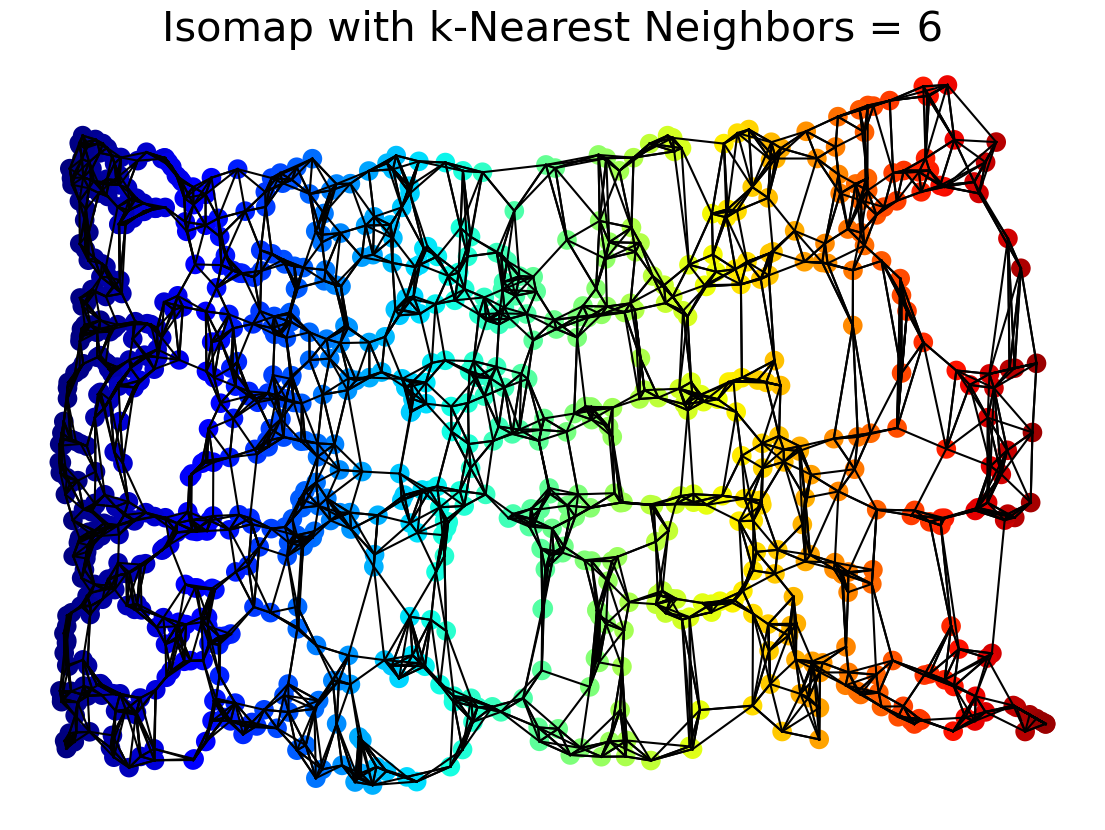

In [9]:
from sklearn.manifold import Isomap
data = X

# apply isomap with k = 6 and output dimension = 2
model = Isomap(n_components=2, n_neighbors=6)
proj = model.fit_transform(data)

# plot the isomap projection
plt.figure(figsize=(14,10))
plt.scatter(proj[:, 0], proj[:, 1], c=plt.cm.jet((X[:,0]**2+X[:,2]**2)/100), s=200, lw=0, alpha=1)

# plot lines connecting the same neighboring points from our original data
for i in range(len(X)):
    neighbors = knn[i]
    for j in range(len(neighbors)):
        plt.plot(proj[[i, neighbors.astype('int')[j]], 0], 
                 proj[[i, neighbors.astype('int')[j]], 1], color='black');
        
plt.title('Isomap with k-Nearest Neighbors = ' + str(k), size=30)
plt.axis("off")
plt.show();

Isomap is able to learn the non-linear structure and produce a two dimensional embedding that unrolls the swiss roll dataset and nicely preserves the pairwise similarities and latent structure. 

### <font color='blue'> Example - Facial Images</font>

We now turn to one of the most common sources of high dimensional data - images. We import the data using `sklearn.datasets`, and we select 30 images per person for ~80 different subjects, where the labels represent each of the targets for image recognition.  

In [10]:
plt.style.use('default')
plt.rcParams['figure.facecolor'] = 'white'

# ignore warnings
import warnings
warnings.filterwarnings('ignore');

(2370, 2914)

(2370, 62, 47)

array(['Alejandro Toledo', 'Alvaro Uribe', 'Andre Agassi', 'Ariel Sharon',
       'Arnold Schwarzenegger', 'Colin Powell', 'David Beckham',
       'Donald Rumsfeld', 'George W Bush', 'Gerhard Schroeder',
       'Gloria Macapagal Arroyo', 'Guillermo Coria', 'Hans Blix',
       'Hugo Chavez', 'Jacques Chirac', 'Jean Chretien',
       'Jennifer Capriati', 'John Ashcroft', 'John Negroponte',
       'Junichiro Koizumi', 'Kofi Annan', 'Laura Bush', 'Lleyton Hewitt',
       'Luiz Inacio Lula da Silva', 'Megawati Sukarnoputri',
       'Nestor Kirchner', 'Recep Tayyip Erdogan', 'Roh Moo-hyun',
       'Serena Williams', 'Silvio Berlusconi', 'Tom Ridge', 'Tony Blair',
       'Vicente Fox', 'Vladimir Putin'], dtype='<U25')

array([ 8,  4, 21, ...,  8, 10,  8])

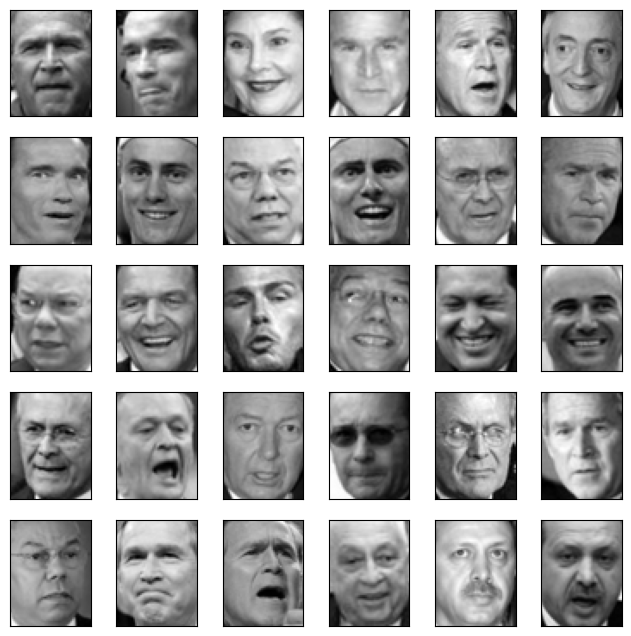

In [11]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=30)
faces.data.shape
faces.images.shape
faces.target_names
faces.target

# plot some images
fig, ax = plt.subplots(5, 6, subplot_kw=dict(xticks=[], yticks=[]), figsize=(8,8))
for i, axi in enumerate(ax.flat):
    _ = axi.imshow(faces.data[i].reshape(62, 47), cmap='gray')
plt.show()

Each data point is an image with $62 \times 47 = 2914$ features that can take values representing pixel intensities. We select all the images of a chosen subject, and see if Isomap can meaningfully reduce the very high dimensionality of the image data.

In [12]:
# define a function to plot small images over the data points
from matplotlib import offsetbox

# source: https://jakevdp.github.io/PythonDataScienceHandbook/05.10-manifold-learning.html
def plot_components(data, model, images=None, ax=None,
                    thumb_frac=0.05, cmap='gray'):
    ax = ax or plt.gca()
    
    proj = model.fit_transform(data)
    ax.plot(proj[:, 0], proj[:, 1], '.k')
    
    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                # don't show points that are too close
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i], cmap=cmap),
                                      proj[i])
            ax.add_artist(imagebox)

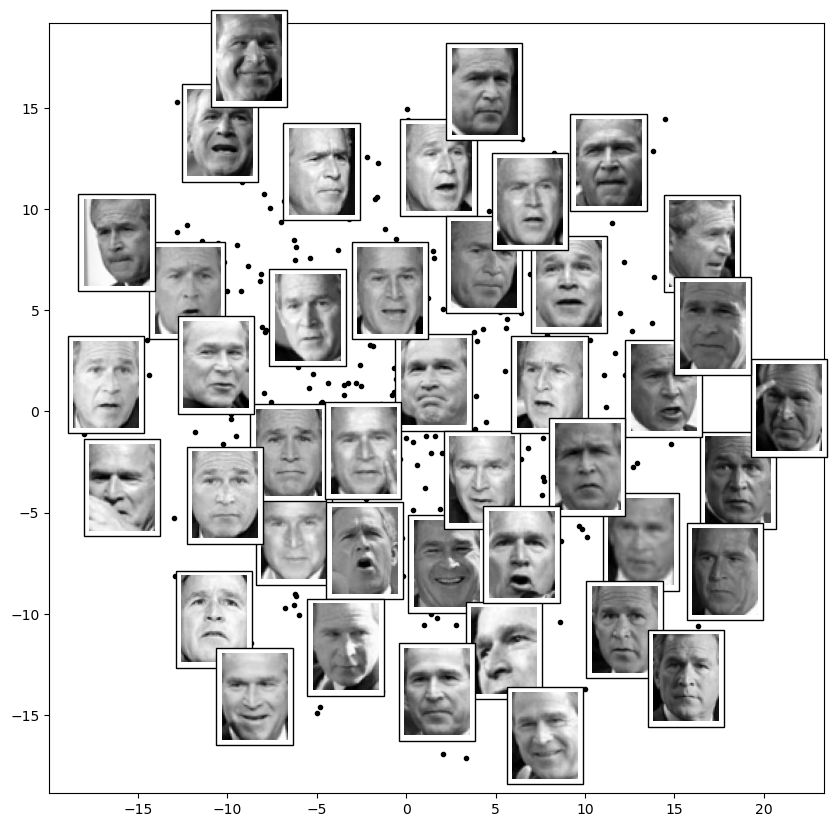

In [13]:
from sklearn.manifold import Isomap
np.random.seed(8888)
fig, ax = plt.subplots(figsize=(10, 10))
data = faces.data[faces.target==8]
images = faces.images[faces.target==8]
faces.target_names[8]
plot_components(data, model=Isomap(n_components=2, n_neighbors=8), images=images, thumb_frac=0.1)
plt.show();

It seems that Isomap does fairly well at preserving some higher dimensional relationships as you can see the images generally get darker and change camera angles while moving across the plane. With only 30 images per person, Isomap will vary substantially in performance across the different subjects.

### <font color='blue'> Example - Object Recognition</font>

We now explore another set of image data, this time the coil-100 dataset with images of 100 random objects. We import one sample image for each object and apply the Isomap algorithm to uncover a two dimensional representation.

In [14]:
import os
import matplotlib.image as img
from skimage.color import rgb2gray
os.getcwd()

def get_sample(path):
    ix = [int(i) for i in np.arange(0, len(os.listdir(path)), 72)]
    object_files = [os.listdir(path)[i] for i in (ix)]

    data = []
    for file in object_files:
        data.append(rgb2gray(plt.imread(path + '/' + file)))
    data = np.array(data)
    images = data
    data = data.reshape(100, 128*128)
    return data, images

path = '/Users/yuzhouwang/CSE6740/Isomap/coil-100'
sample_data, sample_images = get_sample(path)
sample_data.shape
sample_images.shape

'/Users/yuzhouwang/CSE6740/Isomap'

(100, 16384)

(100, 128, 128)

In [15]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'petroff10', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


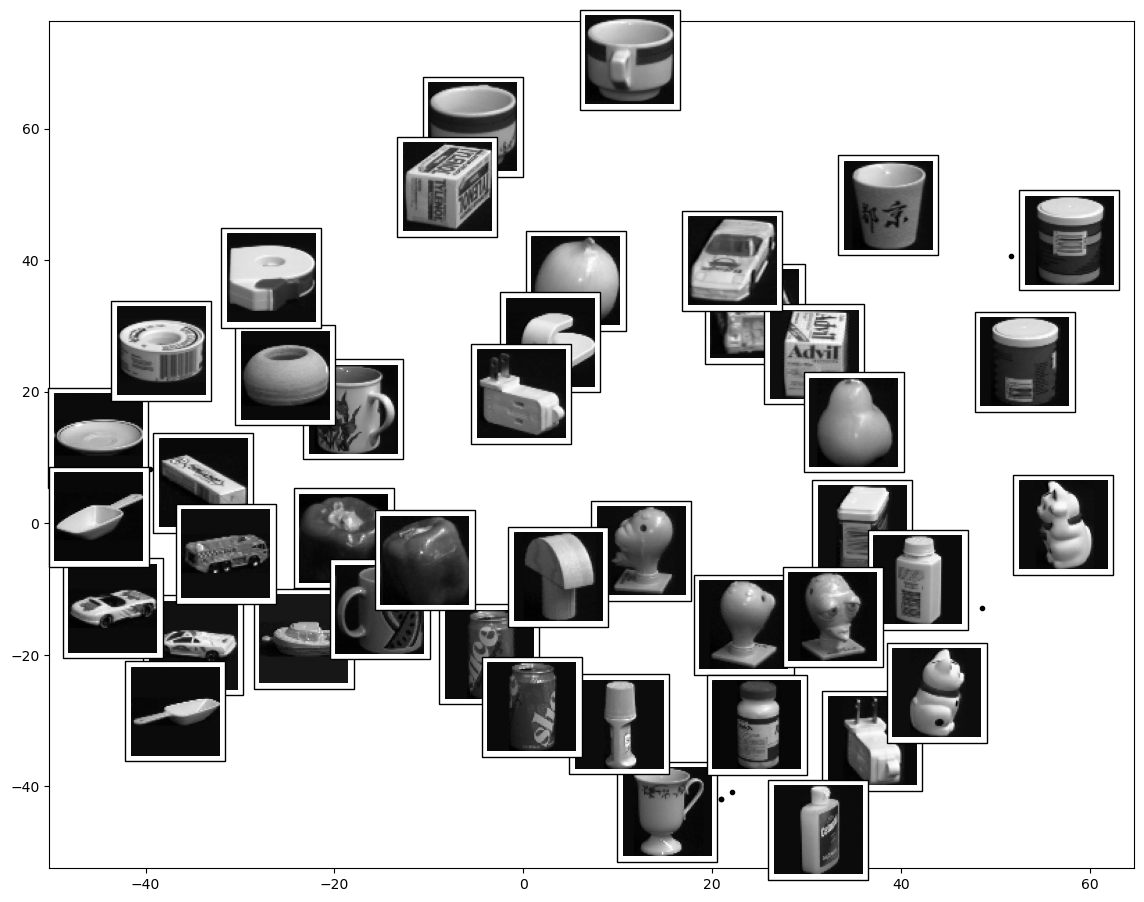

In [16]:
from sklearn.manifold import Isomap
plt.style.use('seaborn-v0_8-bright')
fig, ax = plt.subplots(figsize=(14, 11))
plot_components(sample_data,
                model=Isomap(n_components=2),
                images=sample_images[:, ::2, ::2],
                thumb_frac=0.07)
plt.show();

Isomap is able to illustrate some interesting underlying structure, such as the clustering of the toy cars, the similarity between the images of coffee mugs and soda cans, and the somewhat surprising patterns that emerge like the semi-clustering of dental floss and hygiene-related products that Isomap was apparently able to uncover. A few more examples of Isomap on the coil-100 dataset are illustrated below.

In [17]:
# read in all the images for a collection of objects
def get_objects(path, keys):
    obj_keys = ['obj' + str(key) + '__' for key in keys]
    data = []
    for obj_key in obj_keys:
        object_files = [x for x in os.listdir(path) if obj_key in x]
        for image in object_files:
            data.append(rgb2gray(plt.imread(path + '/' + image)))

    data = np.array(data)
    images = data
    data = data.reshape(len(keys)*72, 128*128)
    return data, images

In [18]:
# select a set of indices for object images
objects = np.arange(1, 90, 15)
object_data, object_images = get_objects(path, objects)
object_data.shape
object_images.shape

(432, 16384)

(432, 128, 128)

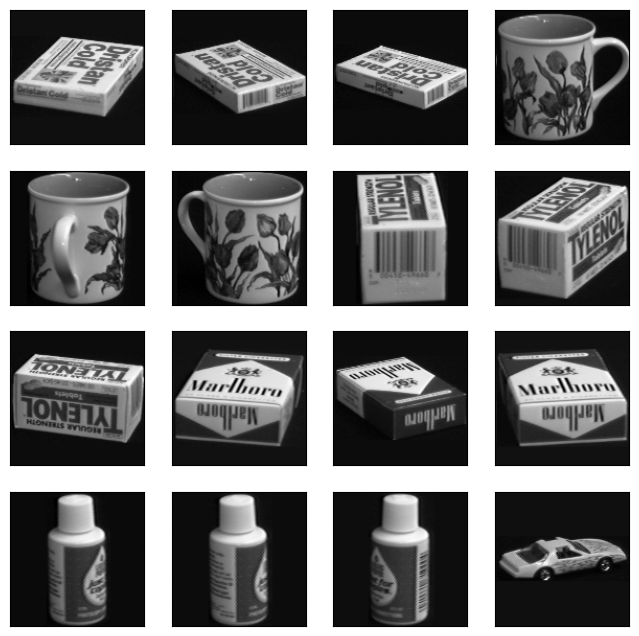

In [19]:
fig, ax = plt.subplots(4, 4, subplot_kw=dict(xticks=[], yticks=[]), figsize=(8,8))
for i, axi in enumerate(ax.flat):
    _ = axi.imshow(object_images[(i+1)*24 - 4], cmap='gray');
plt.show();

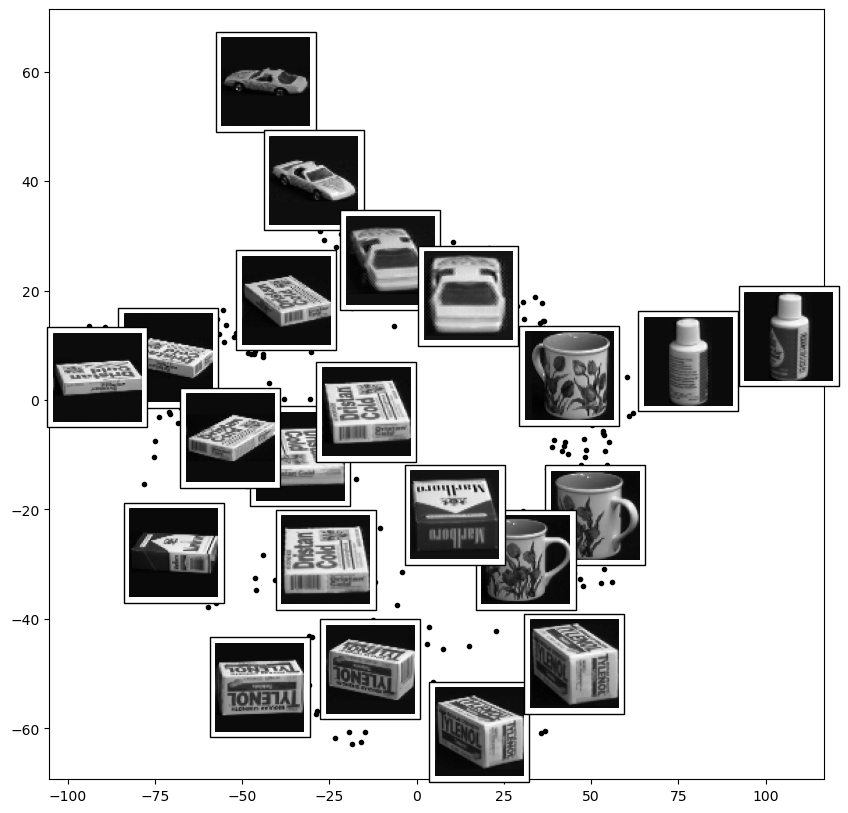

In [20]:
from sklearn.manifold import Isomap
fig, ax = plt.subplots(figsize=(10, 10))
plot_components(object_data, 
                model=Isomap(n_components=2, n_neighbors=15),
                images=object_images[:, ::2, ::2],
                thumb_frac=0.1)
plt.show();

Here the objects are clearly clustered, and manifold learning is especially useful in this case where there's a clear intrinsic dimensionality. The range of different camera angles for each of the objects represents much of the variation in the data, and since these objects seem to have only a few degrees of rotational freedom, this inherent lower dimensional structure can be analyzed.

In [21]:
from IPython.core.display import HTML

def css_styling():
    styles = open("custom_style.css", "r").read()
    return HTML(styles)
css_styling()

___

### References


-  [1] _A Global Geometric Framework for Nonlinear Dimensionality Reduction,_
J. B. Tenenbaum, V. de Silva and J. C. Langford,
Science 290 (5500): 2319-2323, 22 December 2000. https://web.mit.edu/cocosci/Papers/sci_reprint.pdf
-  [2] https://en.wikipedia.org/wiki/Centering_matrix
-  [3] Wickelmaier, Florian. "An introduction to MDS." Sound Quality Research Unit, Aalborg University, Denmark (2003)